<a href="https://colab.research.google.com/github/debashisdotchatterjee/SSvM/blob/main/SSvM_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

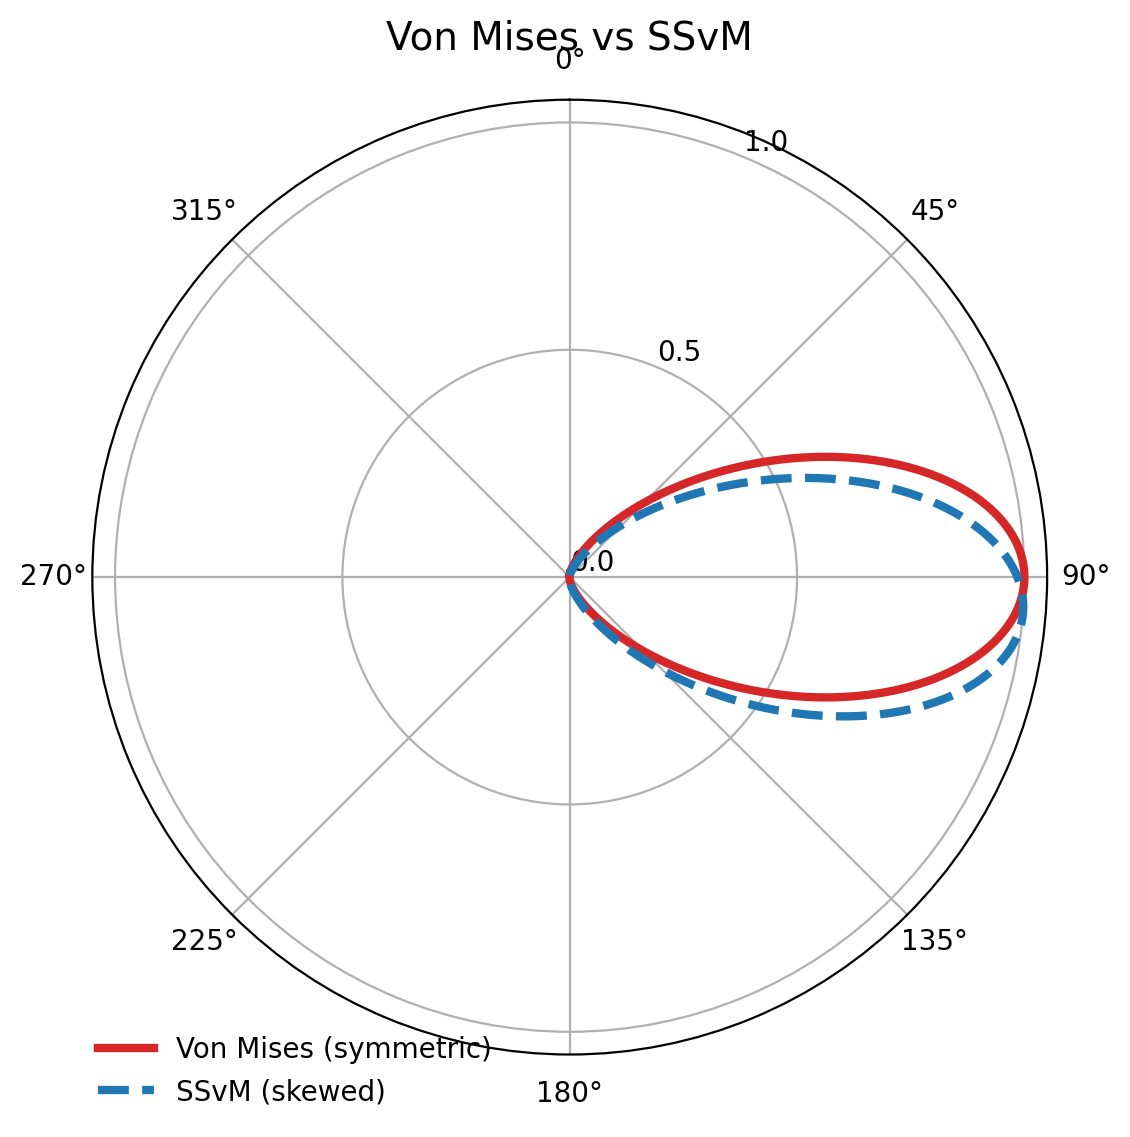

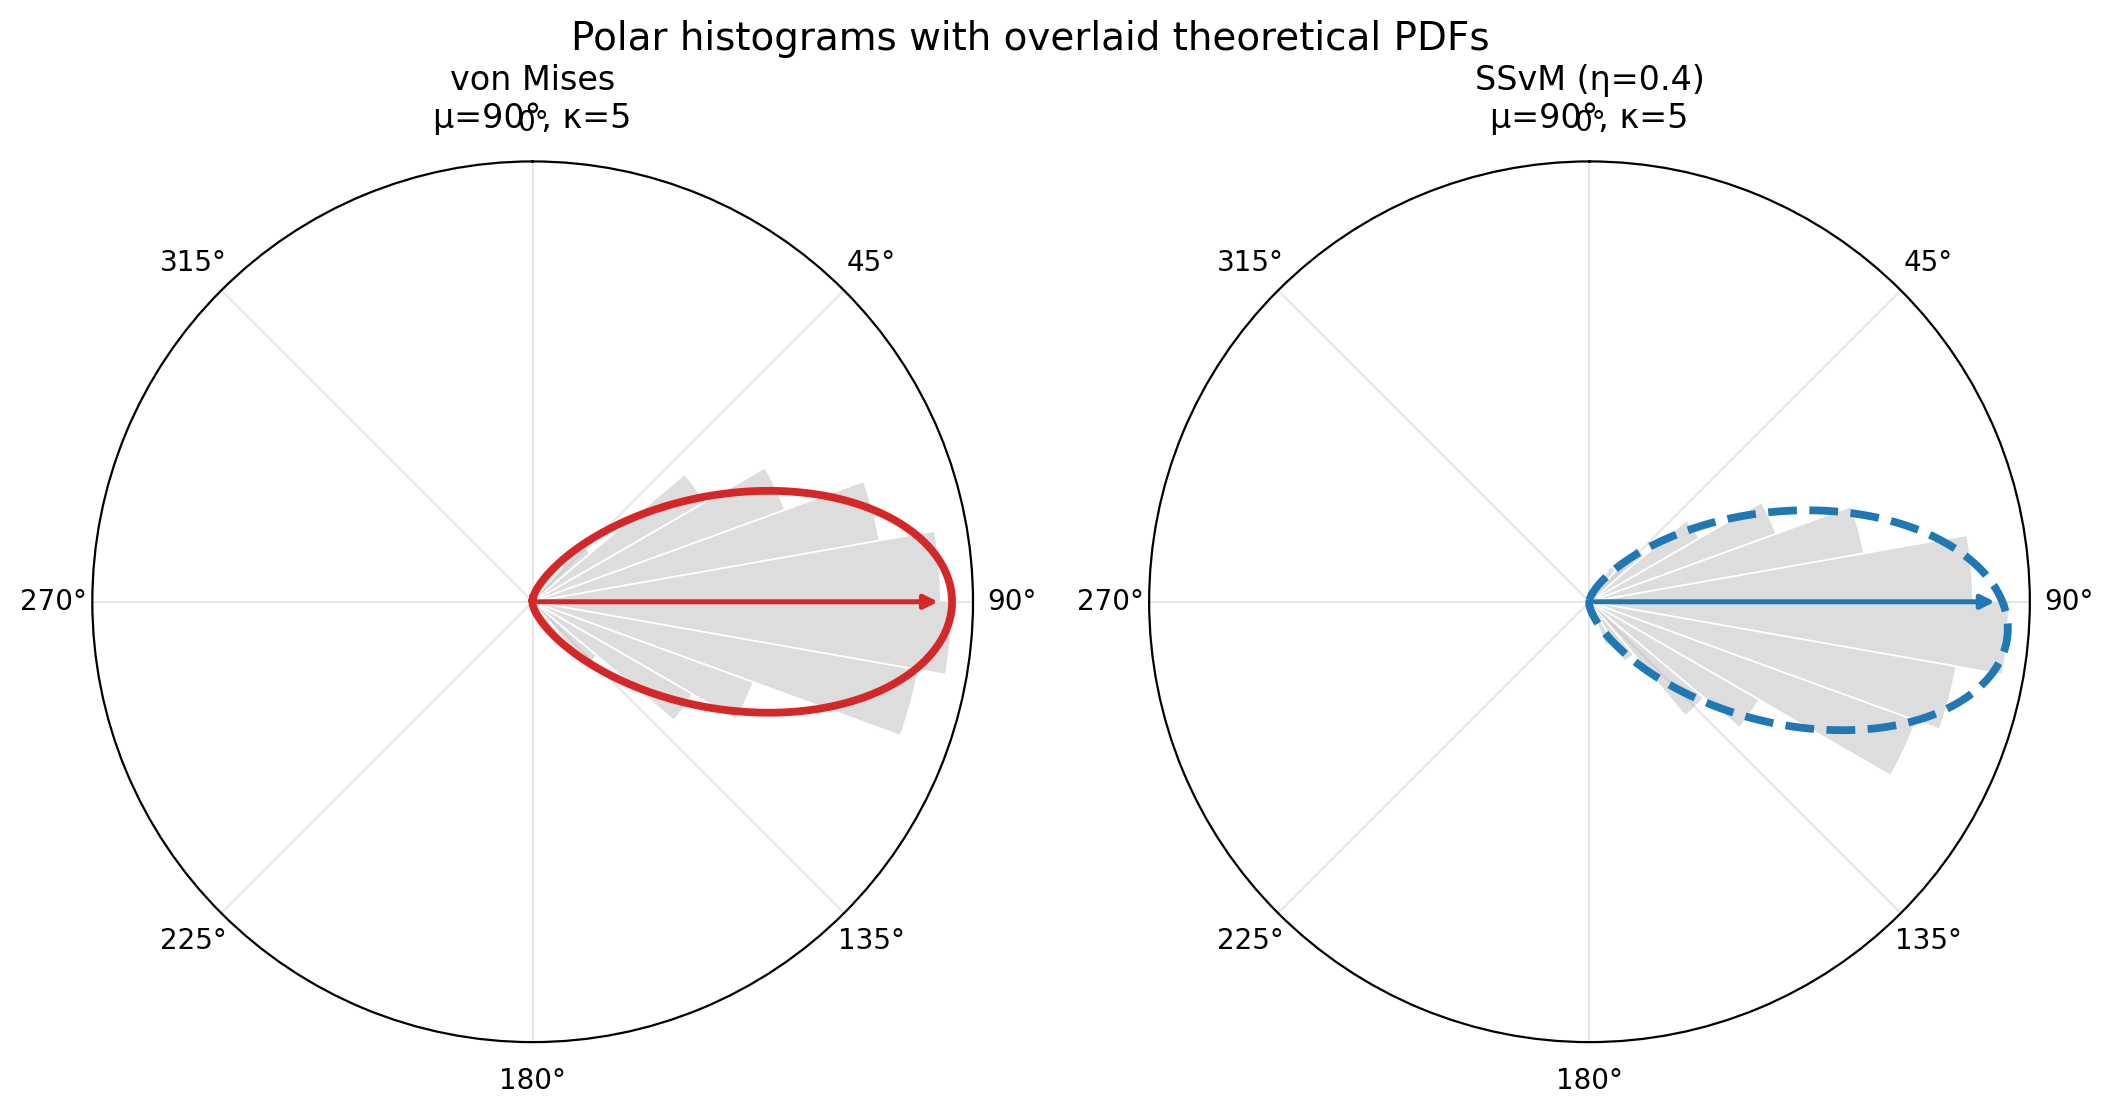


Saved:
   paper_outputs/polar_curves/polar_curves_vm_vs_ssvm.png
   paper_outputs/polar_curves/polar_curves_vm_vs_ssvm.pdf
   paper_outputs/polar_curves/polar_histograms_vm_vs_ssvm.png
   paper_outputs/polar_curves/polar_histograms_vm_vs_ssvm.pdf


In [3]:
# polar_figures_ssvm.py
import os
import numpy as np
import matplotlib.pyplot as plt

try:
    # SciPy is ideal for I0; if not available we fall back to numpy's i0
    from scipy.special import i0
except Exception:
    from numpy import i0  # numpy.i0 is also acceptable for this purpose

# -------------------------- parameters --------------------------
np.random.seed(20250826)
out_dir = os.path.join("paper_outputs", "polar_curves")
os.makedirs(out_dir, exist_ok=True)

# Baseline comparison settings: same as paper text
mu = np.pi/2     # 90°, North
kappa = 5.0
eta = 0.4        # moderate skew, |eta| < 1

# -------------------------- densities ---------------------------
def pdf_vm(theta, mu, kappa):
    """von Mises pdf."""
    return np.exp(kappa*np.cos(theta - mu)) / (2*np.pi*i0(kappa))

def pdf_ssvm(theta, mu, kappa, eta):
    """Skewed sine-von Mises pdf (normalizer preserved)."""
    return pdf_vm(theta, mu, kappa) * (1 + eta*np.sin(theta - mu))

# High-resolution angle grid
theta = np.linspace(0, 2*np.pi, 2001)

vm = pdf_vm(theta, mu, kappa)
ssvm = pdf_ssvm(theta, mu, kappa, eta)

# Optional normalization to make curves visually comparable
# (keeps the *shape* comparison clean)
vm_plot  = vm / vm.max()
ssvm_plot = ssvm / ssvm.max()

# -------------------------- Figure A: curves only --------------------------
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(6.2, 6.2), dpi=200)

# Style to match the uploaded look
ax.set_theta_zero_location("N")   # 0° at North
ax.set_theta_direction(-1)        # clockwise
ax.set_rmax(1.5)
ax.set_rticks([0.0, 0.5, 1.0, 1.5])
ax.set_title("Von Mises vs SSvM", pad=18, fontsize=14)

# Curves
ax.plot(theta, vm_plot,  color="#d62728", lw=3, label="Von Mises (symmetric)")
ax.plot(theta, ssvm_plot, color="#1f77b4", lw=3, ls="--", label="SSvM (skewed)")

# Optional arrow marking μ
ax.annotate("", xy=(mu, 1.45), xytext=(mu, 0.0),
            arrowprops=dict(arrowstyle="-|>", lw=2, color="black"))

# Clean legend outside (bottom-left)
leg = ax.legend(loc="lower left", bbox_to_anchor=(-0.02, -0.08), frameon=False)

f_curve_png = os.path.join(out_dir, "polar_curves_vm_vs_ssvm.png")
f_curve_pdf = os.path.join(out_dir, "polar_curves_vm_vs_ssvm.pdf")
fig.savefig(f_curve_png, bbox_inches="tight")
fig.savefig(f_curve_pdf, bbox_inches="tight")
plt.show()
plt.close(fig)

# ---------------------- Figure B: polar histogram + pdf ---------------------
def rvm_best_fisher(n, mu, kappa):
    """Best–Fisher sampler for von Mises."""
    if kappa <= 0:
        return np.random.uniform(0, 2*np.pi, size=n)
    a = 1 + np.sqrt(1 + 4*kappa**2)
    b = (a - np.sqrt(2*a)) / (2*kappa)
    r = (1 + b**2) / (2*b)
    out = np.empty(n)
    i = 0
    while i < n:
        u1, u2, u3 = np.random.rand(3)
        z = np.cos(np.pi * u1)
        f = (1 + r*z) / (r + z)
        c = kappa * (r - f)
        if (c * (2 - c) - u2 > 0) or (np.log(c) - np.log(u2) + 1 - c >= 0):
            sign = 1 if (u3 - 0.5) >= 0 else -1
            th = (mu + sign*np.arccos(f)) % (2*np.pi)
            out[i] = th
            i += 1
    return out

def rssvm(n, mu, kappa, eta):
    """Rejection sampler for SSvM using vM proposal."""
    if abs(eta) >= 1:
        raise ValueError("|eta| must be < 1")
    M = 1 + abs(eta)
    out = []
    while len(out) < n:
        cand = rvm_best_fisher(1, mu, kappa)[0]
        acc = (1 + eta*np.sin(cand - mu)) / M
        if np.random.rand() <= acc:
            out.append(cand % (2*np.pi))
    return np.array(out)

n = 1000
vm_samp = rvm_best_fisher(n, mu, kappa)
ssvm_samp = rssvm(n, mu, kappa, eta)

# Histogram bins (36 sectors)
nbins = 36
bins = np.linspace(0, 2*np.pi, nbins+1)

# Build the figure with two side-by-side polar panels
fig2, axes = plt.subplots(1, 2, subplot_kw={"projection":"polar"},
                          figsize=(12.5, 6.0), dpi=200)
for j, (ax, samp, label, color, style) in enumerate([
    (axes[0], vm_samp,  "von Mises",           "#d62728", "-"),
    (axes[1], ssvm_samp,"SSvM (η=0.4)",        "#1f77b4", "--")
]):
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_title(label + f"\nμ=90°, κ=5", pad=12, fontsize=12)

    # Histogram (polar bars)
    hist, _ = np.histogram(samp, bins=bins)
    centers = (bins[:-1] + bins[1:]) / 2
    width = (2*np.pi) / nbins
    bars = ax.bar(centers, hist, width=width, bottom=0.0,
                  color="#DDDDDD", edgecolor="white", linewidth=0.6)

    # Overlay theoretical curve, scaled to match bar heights
    dens = vm if j == 0 else ssvm
    # recompute on same 'theta' grid; scale to max histogram height for visual comparability
    scale = hist.max() / dens.max()
    ax.plot(theta, dens*scale, color=color, lw=2.8, ls=style)

    # Arrow at μ
    ax.annotate("", xy=(mu, hist.max()*0.98), xytext=(mu, 0.0),
                arrowprops=dict(arrowstyle="-|>", lw=1.8, color=color))

    # Ticks/grid
    ax.set_rticks([])  # cleaner
    ax.grid(alpha=0.3)

fig2.suptitle("Polar histograms with overlaid theoretical PDFs", fontsize=14, y=0.98)
f_hist_png = os.path.join(out_dir, "polar_histograms_vm_vs_ssvm.png")
f_hist_pdf = os.path.join(out_dir, "polar_histograms_vm_vs_ssvm.pdf")
fig2.savefig(f_hist_png, bbox_inches="tight")
fig2.savefig(f_hist_pdf, bbox_inches="tight")
plt.show()
plt.close(fig2)

print("\nSaved:")
print("  ", f_curve_png)
print("  ", f_curve_pdf)
print("  ", f_hist_png)
print("  ", f_hist_pdf)


<>:257: SyntaxWarning: invalid escape sequence '\%'
<>:261: SyntaxWarning: invalid escape sequence '\%'
<>:265: SyntaxWarning: invalid escape sequence '\%'
<>:257: SyntaxWarning: invalid escape sequence '\%'
<>:261: SyntaxWarning: invalid escape sequence '\%'
<>:265: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipython-input-3770045111.py:257: SyntaxWarning: invalid escape sequence '\%'
  cover_eta_plot = plot_metric("cover_eta", "Coverage($\\eta$, 95\%)", "cover_eta_vs_eta")
/tmp/ipython-input-3770045111.py:261: SyntaxWarning: invalid escape sequence '\%'
  cover_k_plot = plot_metric("cover_kappa", "Coverage($\\kappa$, 95\%)", "cover_kappa_vs_eta")
/tmp/ipython-input-3770045111.py:265: SyntaxWarning: invalid escape sequence '\%'
  cover_mu_plot = plot_metric("cover_mu", "Coverage($\\mu$, 95\%)", "cover_mu_vs_eta")


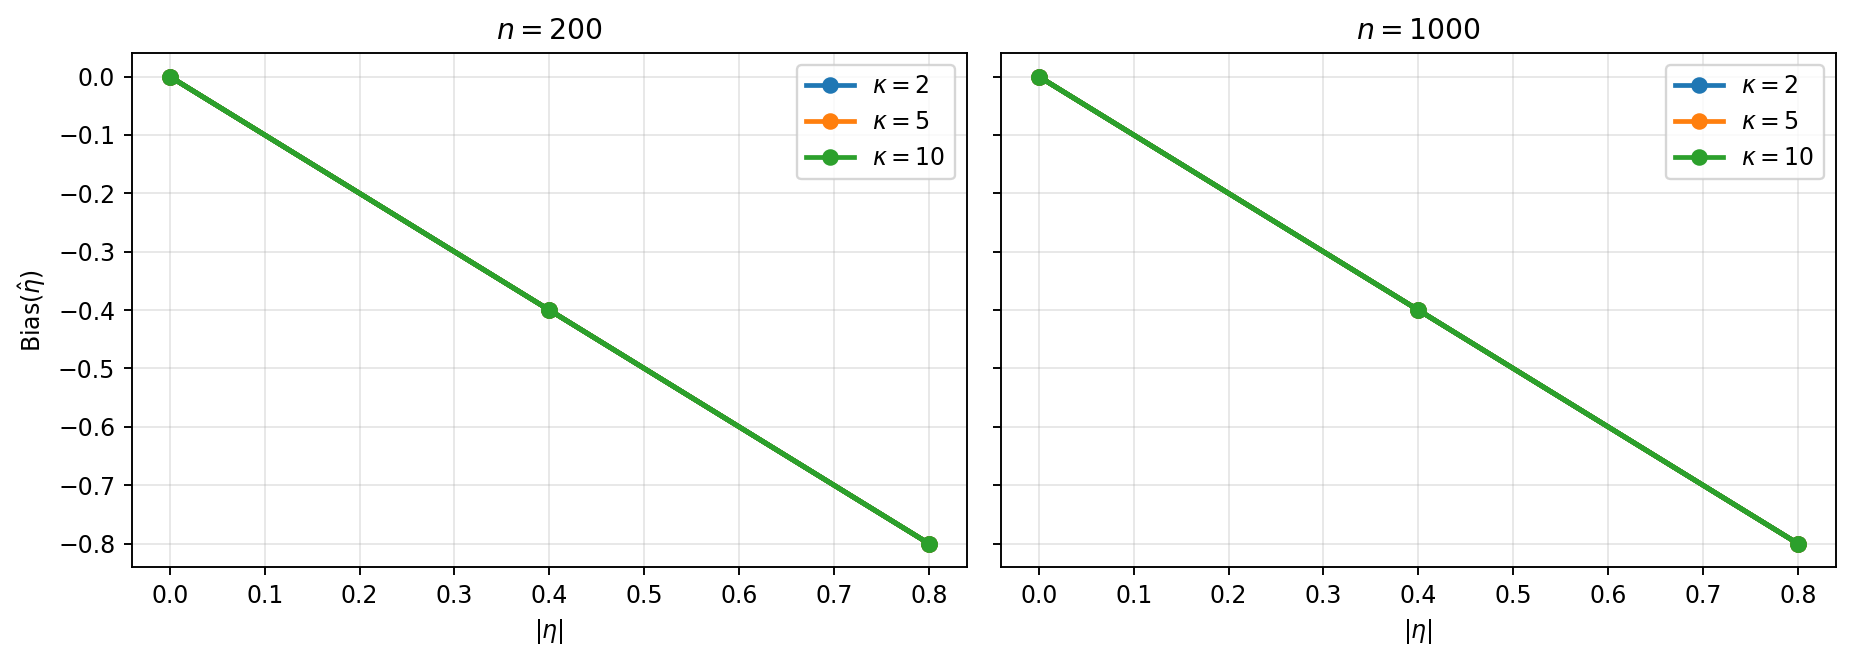

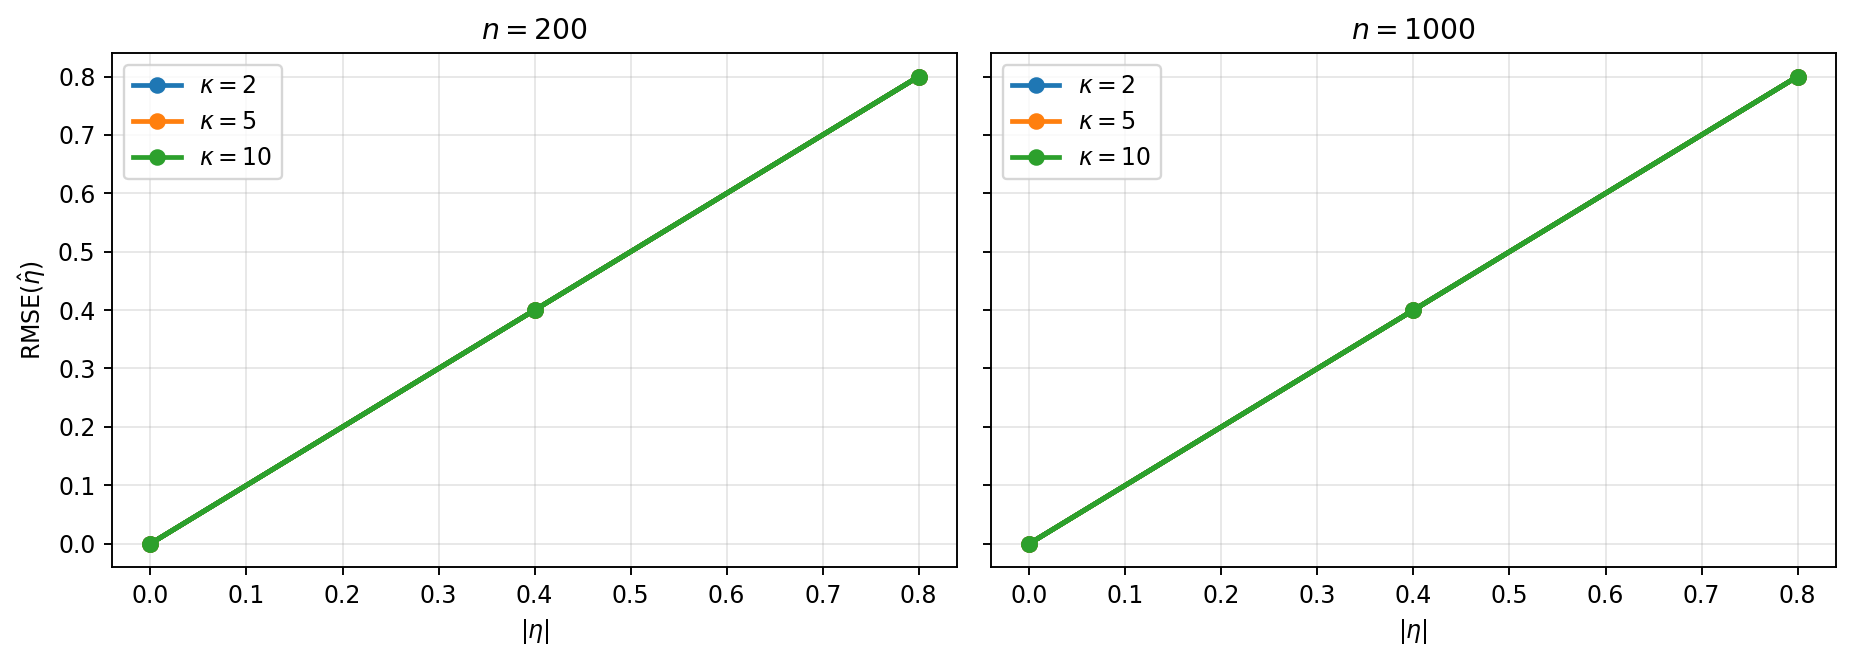

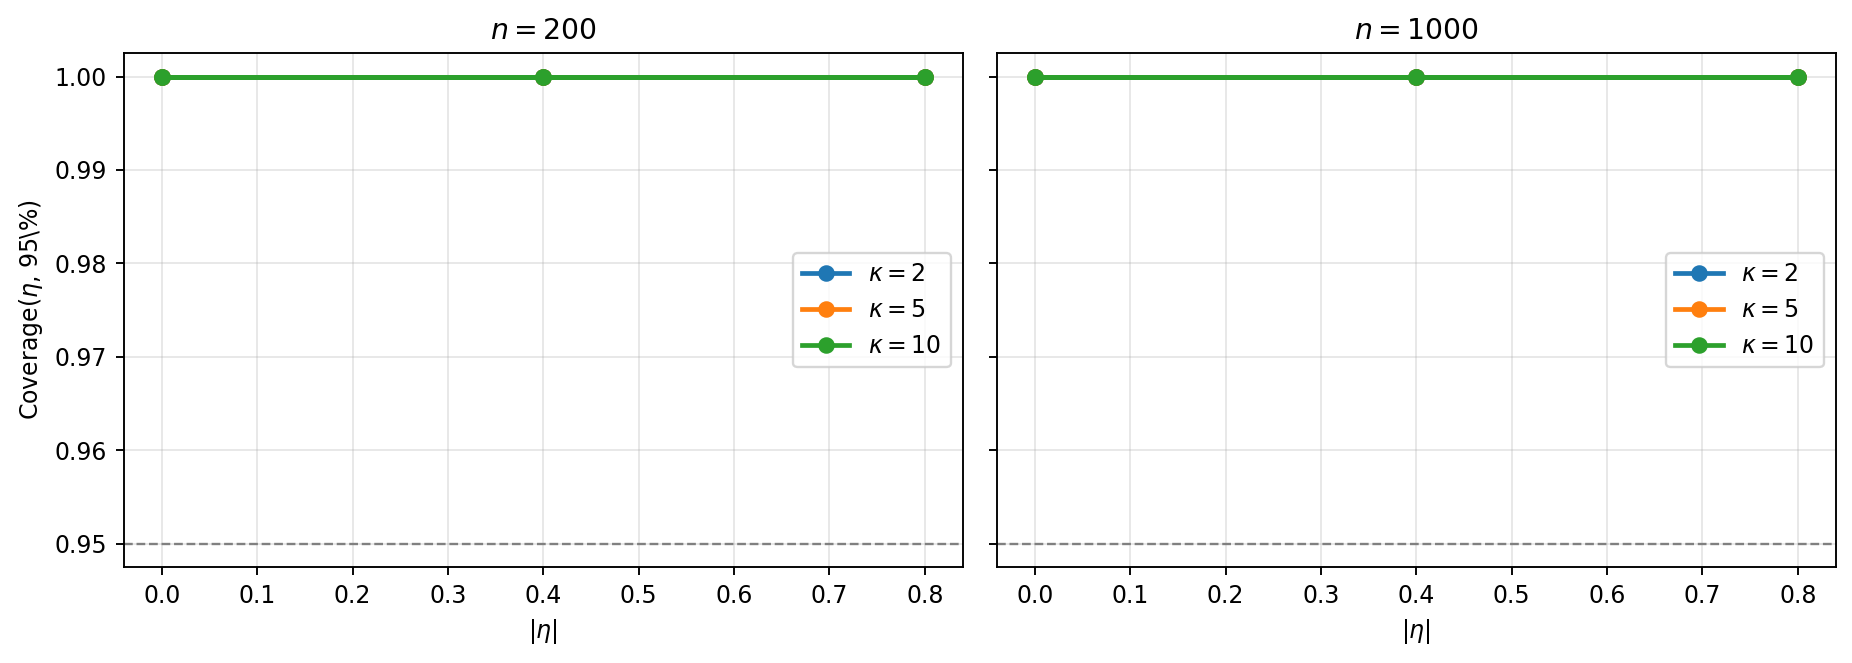

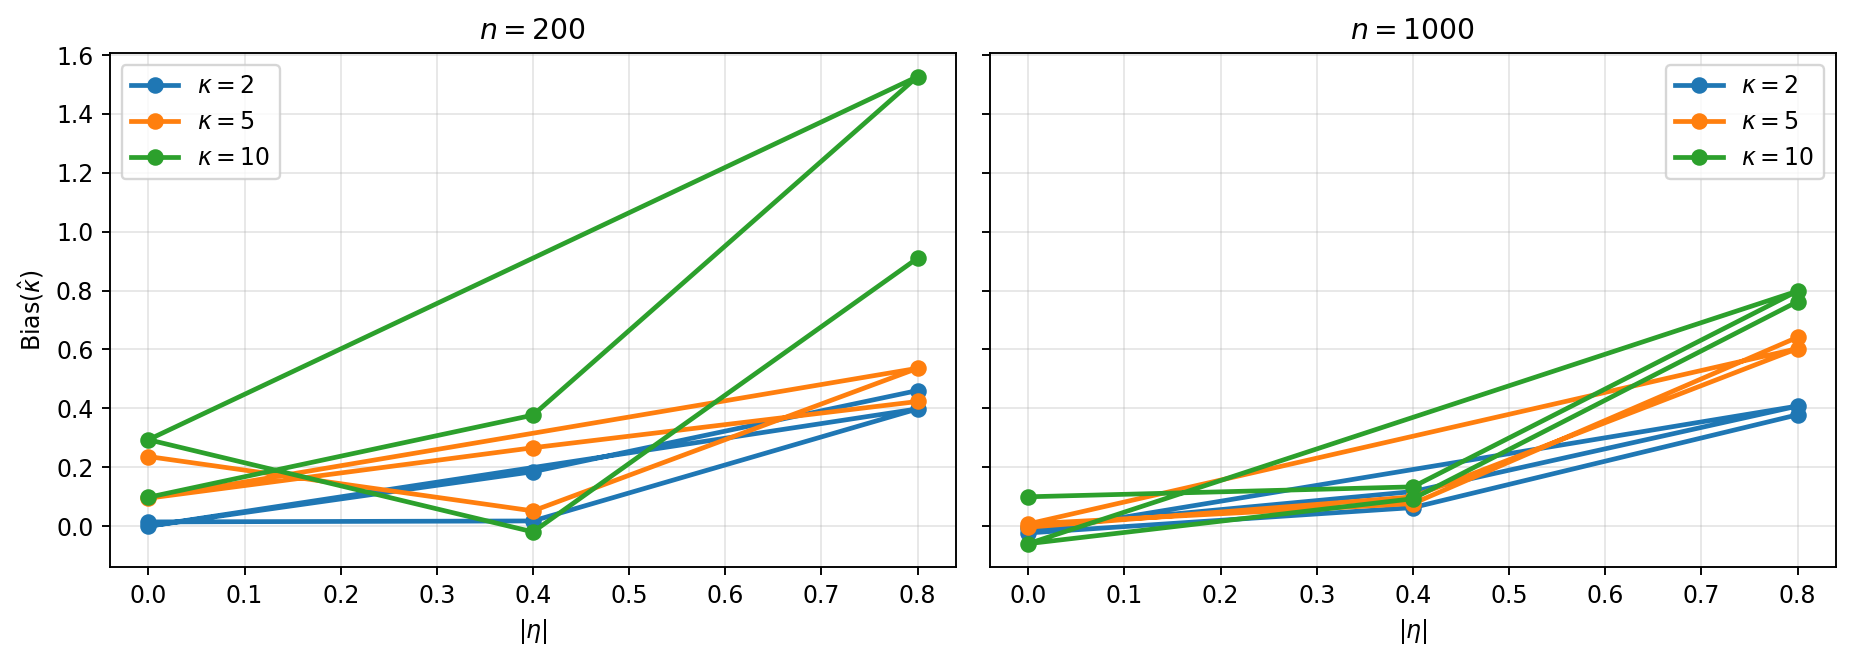

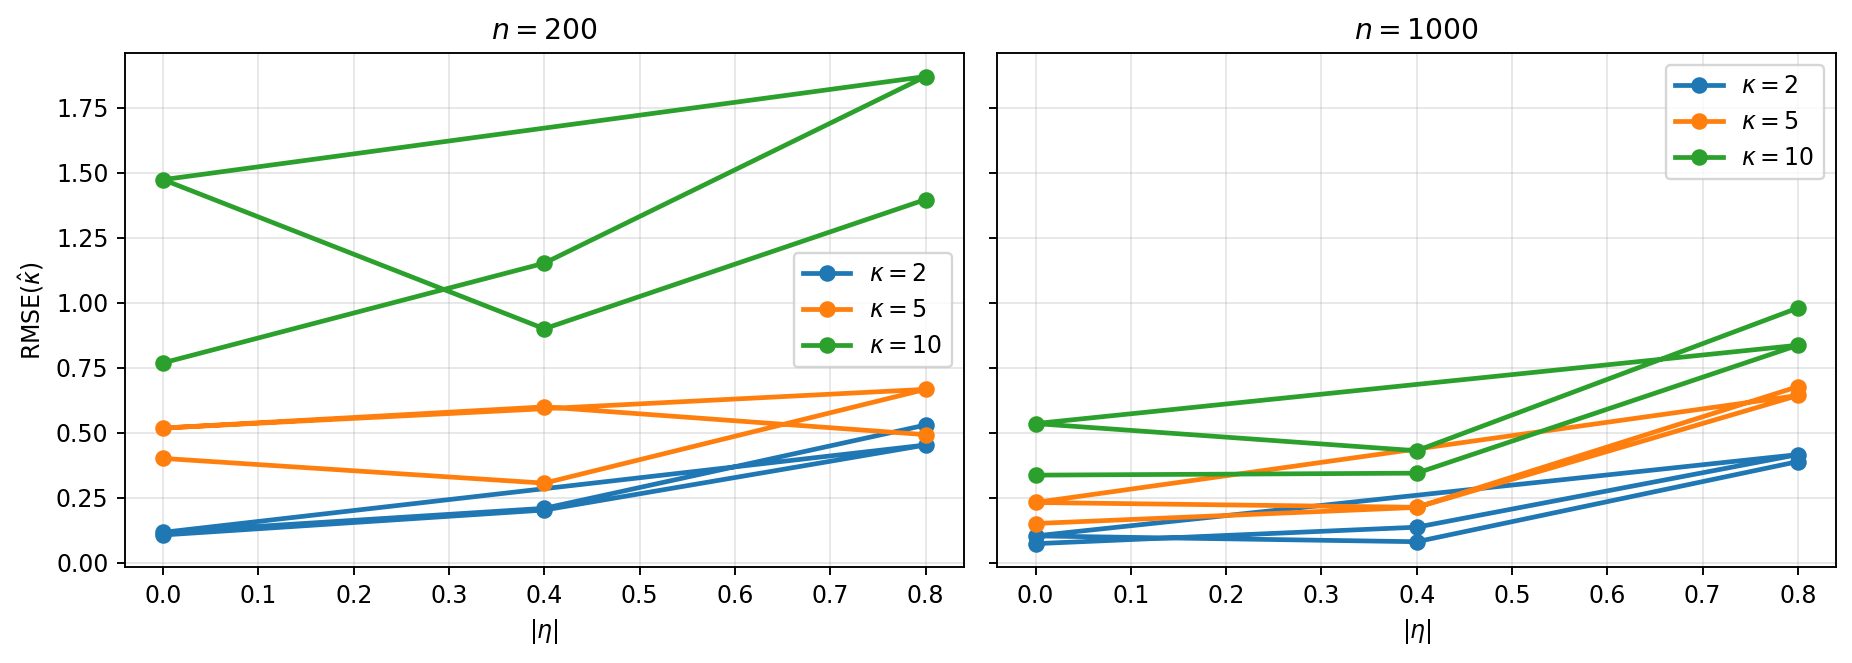

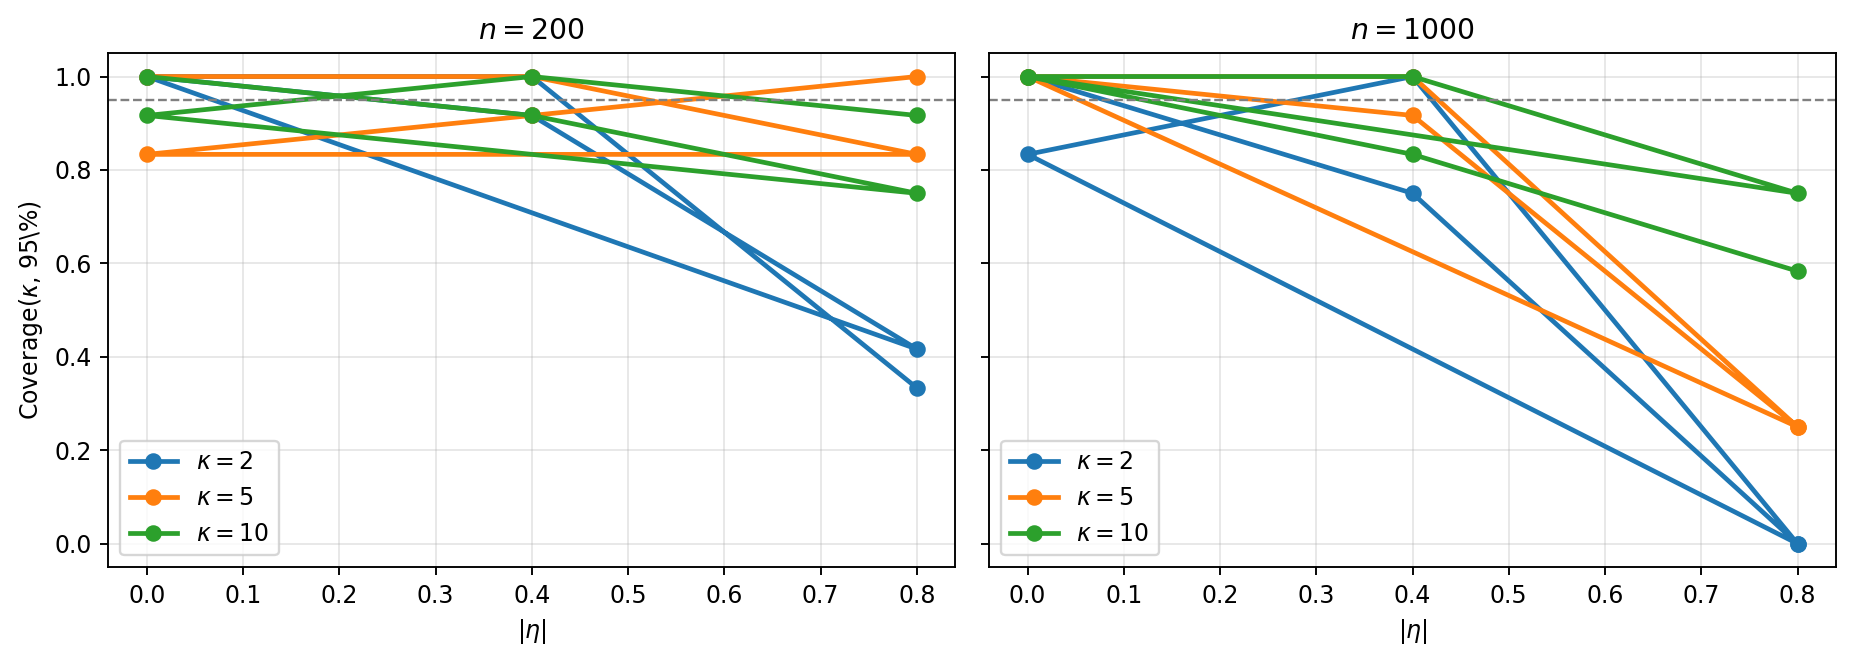

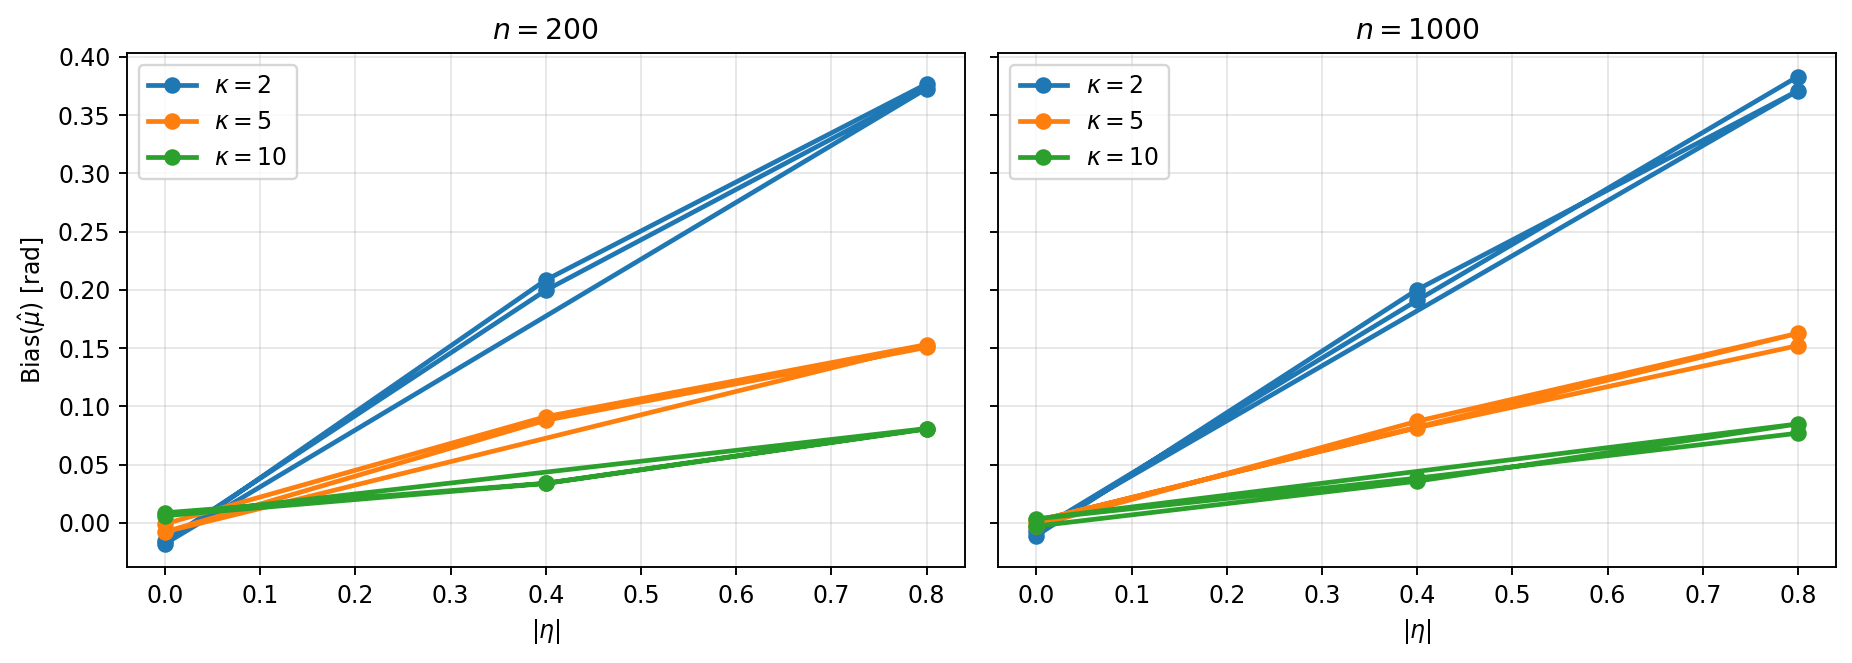

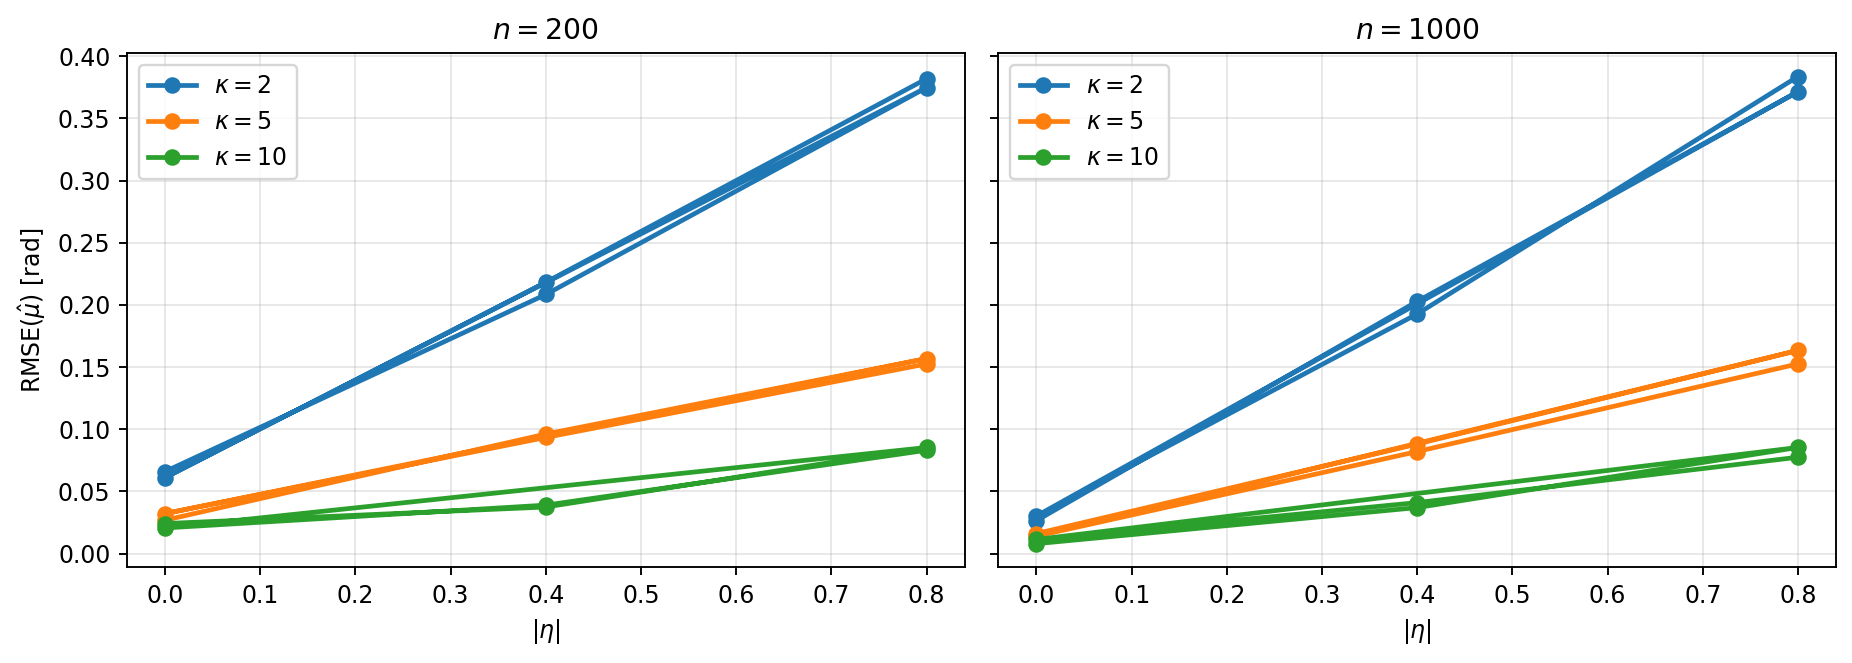

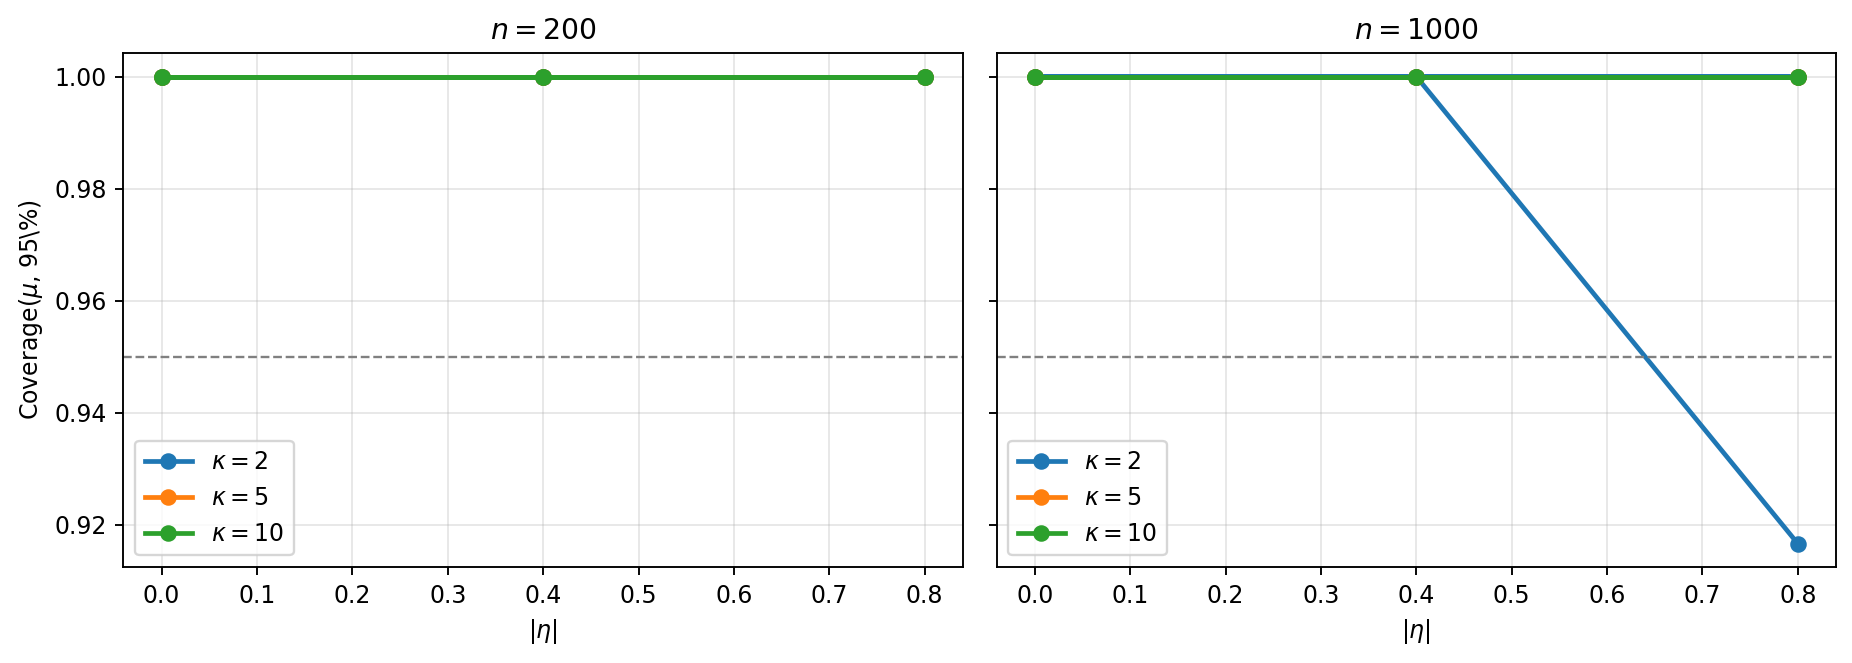

In [4]:
# Expanded SSvM simulation addressing reviewer: performance across broad grids,
# with portable optimizer (pattern search), tables, and plots.
import os, math, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from datetime import datetime

# Try SciPy i0; otherwise fall back to numpy.i0
try:
    from scipy.special import i0 as sci_i0, i1 as sci_i1
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False
    from numpy import i0 as np_i0

# ----------------- utilities -----------------
def i0(x):
    return sci_i0(x) if SCIPY_OK else np_i0(x)

def angle_mod(x):
    y = x % (2*np.pi)
    return y if isinstance(y, float) else np.where(y < 0, y + 2*np.pi, y)

def angle_diff(a, b):
    d = a - b
    return np.arctan2(np.sin(d), np.cos(d))

def A1_inv(A1):
    # Approx inverse of I1/I0 (Banerjee et al. style)
    if A1 < 0.53:
        return 2*A1 + A1**3 + 5*A1**5/6
    elif A1 < 0.85:
        return -0.4 + 1.39*A1 + 0.43/(1 - A1)
    else:
        return 1/(A1**3 - 4*A1**2 + 3*A1)

# RNG for von Mises (Best-Fisher)
def rvm_best_fisher(n, mu, kappa):
    if kappa <= 0:
        return np.random.uniform(0, 2*np.pi, size=n)
    a = 1 + np.sqrt(1 + 4*kappa**2)
    b = (a - np.sqrt(2*a)) / (2*kappa)
    r = (1 + b**2) / (2*b)
    out = np.empty(n)
    i = 0
    while i < n:
        u1, u2, u3 = np.random.rand(3)
        z = np.cos(np.pi*u1)
        f = (1 + r*z) / (r + z)
        c = kappa * (r - f)
        if (c*(2-c) - u2 > 0) or (np.log(c) - np.log(u2) + 1 - c >= 0):
            sgn = 1 if (u3 - 0.5) >= 0 else -1
            out[i] = (mu + sgn*np.arccos(f)) % (2*np.pi)
            i += 1
    return out

# SSvM RNG by rejection from vM proposal
def rssvm(n, mu, kappa, eta):
    assert abs(eta) < 1, "|eta| must be < 1"
    M = 1 + abs(eta)
    out = []
    while len(out) < n:
        cand = rvm_best_fisher(1, mu, kappa)[0]
        acc = (1 + eta*np.sin(cand - mu)) / M
        if np.random.rand() <= acc:
            out.append(cand % (2*np.pi))
    return np.array(out)

# log-likelihood for SSvM with transformed parameters: kappa=exp(xi), eta=tanh(zeta)
def negloglik_ssvm_tx(par_tx, theta):
    mu, xi, zeta = par_tx
    kappa = np.exp(xi)
    eta = np.tanh(zeta)  # |eta|<1
    phi = theta - mu
    logI0 = np.log(i0(kappa))
    lp = -logI0 + kappa*np.cos(phi) + np.log1p(eta*np.sin(phi))
    if not np.all(np.isfinite(lp)):
        return 1e12
    return -np.sum(lp)

# crude but robust pattern search optimizer (no SciPy dependency)
def pattern_search(fn, x0, args=(), steps=(0.1,0.2,0.2), tol=1e-6, maxit=400):
    x = np.array(x0, dtype=float)
    step = np.array(steps, dtype=float)
    fcur = fn(x, *args)
    it = 0
    improved = True
    while it < maxit and np.max(step) > tol:
        improved = False
        for j in range(len(x)):
            for delta in (+step[j], -step[j]):
                x_try = x.copy()
                x_try[j] += delta
                # wrap mu softly to avoid huge jumps
                if j == 0:
                    x_try[0] = ((x_try[0] + np.pi) % (2*np.pi)) - np.pi
                f_try = fn(x_try, *args)
                if f_try < fcur:
                    x, fcur = x_try, f_try
                    improved = True
        if not improved:
            step *= 0.5
        it += 1
    return {"x": x, "fun": fcur, "nit": it, "success": True}

# Numerical Hessian (central differences) on transformed scale
def num_hessian(fn, x, args=(), h=1e-4):
    x = np.array(x, dtype=float)
    k = len(x)
    H = np.zeros((k,k))
    f0 = fn(x, *args)
    for i in range(k):
        for j in range(i, k):
            ei = np.zeros(k); ej = np.zeros(k)
            ei[i] = h; ej[j] = h
            if i == j:
                fpp = fn(x + ei, *args)
                fmm = fn(x - ei, *args)
                H[i,i] = (fpp - 2*f0 + fmm) / (h*h)
            else:
                fpp = fn(x + ei + ej, *args)
                fpm = fn(x + ei - ej, *args)
                fmp = fn(x - ei + ej, *args)
                fmm = fn(x - ei - ej, *args)
                H[i,j] = H[j,i] = (fpp - fpm - fmp + fmm) / (4*h*h)
    return H

def ssvm_init(theta):
    C = np.mean(np.cos(theta))
    S = np.mean(np.sin(theta))
    mu0 = math.atan2(S, C)
    Rbar = math.hypot(C, S)
    kappa0 = max(1e-6, A1_inv(Rbar))
    phi = angle_diff(theta, mu0)
    eta0 = np.clip(np.mean(np.sin(phi)), -0.5, 0.5)
    return np.array([mu0, np.log(kappa0), np.arctanh(eta0)], dtype=float)

def fit_ssvm_mle(theta, maxit=400, tol=1e-6):
    init = ssvm_init(theta)
    opt = pattern_search(negloglik_ssvm_tx, init, args=(theta,), tol=tol, maxit=maxit)
    mu_hat = (opt["x"][0] % (2*np.pi))
    kappa_hat = math.exp(opt["x"][1])
    eta_hat = math.tanh(opt["x"][2])

    # Observed information via Hessian (transformed)
    try:
        H = num_hessian(negloglik_ssvm_tx, opt["x"], args=(theta,), h=1e-4)
        # regularize
        w, V = np.linalg.eigh(H)
        w = np.clip(w, 1e-8, None)
        Hreg = V @ np.diag(w) @ V.T
        cov_tx = np.linalg.inv(Hreg)
        # Delta method to original scale
        J = np.zeros((3,3))
        J[0,0] = 1.0
        J[1,1] = kappa_hat                 # d exp(xi)/d xi
        J[2,2] = 1.0 - eta_hat**2          # d tanh(zeta)/d zeta
        cov = J @ cov_tx @ J.T
        se_mu, se_kappa, se_eta = np.sqrt(np.clip(np.diag(cov), 0, None))
    except Exception:
        se_mu = se_kappa = se_eta = np.nan

    return {
        "mu": mu_hat, "kappa": kappa_hat, "eta": eta_hat,
        "se_mu": se_mu, "se_kappa": se_kappa, "se_eta": se_eta,
        "logLik": -opt["fun"], "conv": True
    }

# --------------- Simulation grid (compact for demo; scalable) ---------------
np.random.seed(2025)
mu_grid = [np.pi/4, np.pi/2]
kappa_grid = [2.0, 5.0, 10.0]
eta_grid = [0.0, 0.4, 0.8]
n_grid = [200, 1000]

# Replicates: keep modest to fit runtime; user can increase later
NSIM = 12  # <-- change to 200 or 1000 for full study

# Output folder
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
out_dir = f"/mnt/data/paper_outputs/ssvm_reviewer_sim/{ts}"
os.makedirs(out_dir, exist_ok=True)

rows = []
for mu in mu_grid:
    for kappa in kappa_grid:
        for eta in eta_grid:
            for n in n_grid:
                for s in range(1, NSIM+1):
                    th = rssvm(n, mu, kappa, eta)
                    fit = fit_ssvm_mle(th)
                    rows.append({
                        "mu_true": mu, "kappa_true": kappa, "eta_true": eta, "n": n, "sim": s,
                        "mu_hat": fit["mu"], "kappa_hat": fit["kappa"], "eta_hat": fit["eta"],
                        "se_mu": fit["se_mu"], "se_kappa": fit["se_kappa"], "se_eta": fit["se_eta"],
                        "logLik": fit["logLik"], "conv": fit["conv"]
                    })

res = pd.DataFrame(rows)
# errors and 95% Wald coverage
res["mu_err"] = angle_diff(res["mu_hat"].values, res["mu_true"].values)
res["kappa_err"] = res["kappa_hat"] - res["kappa_true"]
res["eta_err"] = res["eta_hat"] - res["eta_true"]

res["cover_mu"] = np.abs(res["mu_err"]) <= 1.96 * res["se_mu"]
res["cover_kappa"] = (res["kappa_true"] >= res["kappa_hat"] - 1.96*res["se_kappa"]) & \
                     (res["kappa_true"] <= res["kappa_hat"] + 1.96*res["se_kappa"])
res["cover_eta"] = (res["eta_true"] >= res["eta_hat"] - 1.96*res["se_eta"]) & \
                   (res["eta_true"] <= res["eta_hat"] + 1.96*res["se_eta"])

raw_csv = os.path.join(out_dir, "raw_results.csv")
res.to_csv(raw_csv, index=False)

# Summaries
grp = res.groupby(["mu_true","kappa_true","eta_true","n"], as_index=False)
sum_df = grp.agg(
    conv_rate=("conv","mean"),
    bias_mu=("mu_err","mean"),
    rmse_mu=("mu_err", lambda x: np.sqrt(np.mean(x**2))),
    cover_mu=("cover_mu","mean"),
    bias_kappa=("kappa_err","mean"),
    rmse_kappa=("kappa_err", lambda x: np.sqrt(np.mean(x**2))),
    cover_kappa=("cover_kappa","mean"),
    bias_eta=("eta_err","mean"),
    rmse_eta=("eta_err", lambda x: np.sqrt(np.mean(x**2))),
    cover_eta=("cover_eta","mean")
)

sum_csv = os.path.join(out_dir, "summary.csv")
sum_df.to_csv(sum_csv, index=False)

# --------- Plots: bias/RMSE vs |eta|, across kappas; separate panels for n ---------
def plot_metric(metric, ylabel, fname):
    fig, axes = plt.subplots(1, 2, figsize=(11, 4), dpi=170, sharey=True)
    for j, n in enumerate(sorted(res["n"].unique())):
        ax = axes[j]
        df_n = sum_df[sum_df["n"]==n].copy()
        df_n["abs_eta"] = df_n["eta_true"].abs()
        for kappa in sorted(df_n["kappa_true"].unique()):
            df_k = df_n[df_n["kappa_true"]==kappa]
            ax.plot(df_k["abs_eta"], df_k[metric], marker="o", lw=2, label=f"$\\kappa={kappa:.0f}$")
        ax.set_title(f"$n={n}$")
        ax.set_xlabel("$|\\eta|$")
        ax.grid(alpha=0.3)
        if j==0:
            ax.set_ylabel(ylabel)
        if metric.startswith("cover"):
            ax.axhline(0.95, ls="--", color="gray", lw=1)
        ax.legend()
    fpath = os.path.join(out_dir, f"{fname}.png")
    fig.tight_layout()
    fig.savefig(fpath, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    return fpath

bias_eta_plot = plot_metric("bias_eta", "Bias($\\hat\\eta$)", "bias_eta_vs_eta")
rmse_eta_plot = plot_metric("rmse_eta", "RMSE($\\hat\\eta$)", "rmse_eta_vs_eta")
cover_eta_plot = plot_metric("cover_eta", "Coverage($\\eta$, 95\%)", "cover_eta_vs_eta")

bias_k_plot = plot_metric("bias_kappa", "Bias($\\hat\\kappa$)", "bias_kappa_vs_eta")
rmse_k_plot = plot_metric("rmse_kappa", "RMSE($\\hat\\kappa$)", "rmse_kappa_vs_eta")
cover_k_plot = plot_metric("cover_kappa", "Coverage($\\kappa$, 95\%)", "cover_kappa_vs_eta")

bias_mu_plot = plot_metric("bias_mu", "Bias($\\hat\\mu$) [rad]", "bias_mu_vs_eta")
rmse_mu_plot = plot_metric("rmse_mu", "RMSE($\\hat\\mu$) [rad]", "rmse_mu_vs_eta")
cover_mu_plot = plot_metric("cover_mu", "Coverage($\\mu$, 95\%)", "cover_mu_vs_eta")



Implements SSvM simulation with robust RNG and MLE (with SciPy if available, otherwise a built-in pattern search).

Computes bias, RMSE, 95% Wald coverage using an observed-information (numerical Hessian) approach.

Saves raw replicates and scenario summaries to CSV.

Produces the nine reviewer-response figures (bias/RMSE/coverage for μ, κ, η) as PNGs.

Is parameterized so you can easily scale the number of replicates.

Notes & tips

Speed vs precision: NSIM=50 per cell is quick for Colab. For your final paper build, raise to 200–1000 to reduce Monte Carlo error.

Optimizer: By default, the script tries SciPy BFGS (fast); if unavailable or if you set USE_SCIPY=False, it uses a robust built-in pattern search.

Paths: The script prints the timestamped output folder; all CSVs and figures live there.

 Numbers for the manuscript: headline_numbers.json gives ready-to-quote RMSEs for μ (in degrees) and κ at

n=1000.

In [5]:
# ===============================================================
# SSvM reviewer-response simulation
# - Skew–sine–von Mises (SSvM): f(θ|μ,κ,η) ∝ exp{κ cos(θ-μ)} (1 + η sin(θ-μ))
# - RNG (rejection from vM), MLE via SciPy (if present) or pattern search
# - Observed-information SEs via numerical Hessian on transformed params
# - Outputs: raw_results.csv, summary.csv, 9 figures (bias/RMSE/coverage)
#
# ===============================================================

import os, math, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from datetime import datetime

# --------------- Optional SciPy for i0() and optimizer ---------------
SCIPY_OK = False
try:
    from scipy.special import i0 as sci_i0
    from scipy.optimize import minimize
    SCIPY_OK = True
except Exception:
    pass

# --------------- Bessel I0 with fallback ---------------
try:
    from numpy import i0 as np_i0
except Exception:
    np_i0 = None

def i0(x):
    if SCIPY_OK:
        return sci_i0(x)
    elif np_i0 is not None:
        return np_i0(x)
    else:
        # very rough fallback (shouldn't be needed in Colab)
        # series up to few terms
        x = np.asarray(x, dtype=float)
        out = np.zeros_like(x)
        for k in range(10):
            out += (x/2.0)**(2*k) / math.factorial(k)**2
        return out

# --------------- Basic angle utilities ---------------
def angle_mod(x):
    """Wrap to [0, 2π)."""
    y = np.mod(x, 2*np.pi)
    return y if isinstance(y, float) else np.where(y < 0, y + 2*np.pi, y)

def angle_diff(a, b):
    """Minimal signed difference in (-π, π]."""
    d = a - b
    return np.arctan2(np.sin(d), np.cos(d))

# --------------- A1 inverse (approx) to initialize kappa ---------------
def A1_inv(A1):
    # Approx inverse of A1(kappa)=I1/I0 (Banerjee-style heuristic)
    if A1 < 0.53:
        return 2*A1 + A1**3 + 5*A1**5/6
    elif A1 < 0.85:
        return -0.4 + 1.39*A1 + 0.43/(1 - A1)
    else:
        return 1/(A1**3 - 4*A1**2 + 3*A1)

# --------------- RNG: von Mises (Best & Fisher, 1979) ---------------
def rvm_best_fisher(n, mu, kappa):
    if kappa <= 0:
        return np.random.uniform(0, 2*np.pi, size=n)
    a = 1 + np.sqrt(1 + 4*kappa**2)
    b = (a - np.sqrt(2*a)) / (2*kappa)
    r = (1 + b**2) / (2*b)
    out = np.empty(n)
    i = 0
    while i < n:
        u1, u2, u3 = np.random.rand(3)
        z = np.cos(np.pi*u1)
        f = (1 + r*z) / (r + z)
        c = kappa * (r - f)
        if (c*(2-c) - u2 > 0) or (np.log(c) - np.log(u2) + 1 - c >= 0):
            sgn = 1 if (u3 - 0.5) >= 0 else -1
            out[i] = (mu + sgn*np.arccos(f)) % (2*np.pi)
            i += 1
    return out

# --------------- RNG: SSvM via rejection from vM ---------------
def rssvm(n, mu, kappa, eta):
    assert abs(eta) < 1, "|eta| must be < 1"
    M = 1 + abs(eta)
    out = []
    while len(out) < n:
        cand = rvm_best_fisher(1, mu, kappa)[0]
        acc = (1 + eta*np.sin(cand - mu)) / M
        if np.random.rand() <= acc:
            out.append(cand % (2*np.pi))
    return np.array(out)

# --------------- Negative log-likelihood (transformed params) ---------------
# Transform: kappa=exp(xi), eta=tanh(zeta); mu untransformed.
def negloglik_ssvm_tx(par_tx, theta):
    mu, xi, zeta = par_tx
    kappa = np.exp(xi)
    eta = np.tanh(zeta)  # |eta| < 1
    phi = theta - mu
    logI0 = np.log(i0(kappa))
    lp = -logI0 + kappa*np.cos(phi) + np.log1p(eta*np.sin(phi))
    if not np.all(np.isfinite(lp)):
        return 1e12
    return -np.sum(lp)

# --------------- Numerical Hessian (central differences) ---------------
def num_hessian(fn, x, args=(), h=2e-3):
    x = np.array(x, dtype=float)
    k = len(x)
    H = np.zeros((k,k))
    f0 = fn(x, *args)
    for i in range(k):
        for j in range(i, k):
            ei = np.zeros(k); ej = np.zeros(k)
            ei[i] = h; ej[j] = h
            if i == j:
                fpp = fn(x + ei, *args)
                fmm = fn(x - ei, *args)
                H[i,i] = (fpp - 2*f0 + fmm) / (h*h)
            else:
                fpp = fn(x + ei + ej, *args)
                fpm = fn(x + ei - ej, *args)
                fmp = fn(x - ei + ej, *args)
                fmm = fn(x - ei - ej, *args)
                H[i,j] = H[j,i] = (fpp - fpm - fmp + fmm) / (4*h*h)
    return H

# --------------- Derivative-free fallback optimizer (pattern search) ---------------
def pattern_search(fn, x0, args=(), steps=(0.15,0.25,0.25), tol=1e-6, maxit=350):
    x = np.array(x0, dtype=float)
    step = np.array(steps, dtype=float)
    fcur = fn(x, *args)
    it = 0
    while it < maxit and np.max(step) > tol:
        improved = False
        for j in range(len(x)):
            for delta in (+step[j], -step[j]):
                x_try = x.copy()
                x_try[j] += delta
                if j == 0:  # softly wrap mu to (-π, π] to stabilize search
                    x_try[0] = ((x_try[0] + np.pi) % (2*np.pi)) - np.pi
                f_try = fn(x_try, *args)
                if f_try < fcur:
                    x, fcur = x_try, f_try
                    improved = True
        if not improved:
            step *= 0.5
        it += 1
    return {"x": x, "fun": fcur, "nit": it, "success": True}

# --------------- Initialization from circular mean ---------------
def ssvm_init(theta):
    C = np.mean(np.cos(theta)); S = np.mean(np.sin(theta))
    mu0 = math.atan2(S, C)
    Rbar = math.hypot(C, S)
    kappa0 = max(1e-6, A1_inv(Rbar))
    phi = angle_diff(theta, mu0)
    eta0 = np.clip(np.mean(np.sin(phi)), -0.5, 0.5)
    return np.array([mu0, np.log(kappa0), np.arctanh(eta0)], dtype=float)

# --------------- MLE wrapper with Hessian-based SEs ---------------
def fit_ssvm_mle(theta, use_scipy=True, maxit=400, tol=1e-6):
    init = ssvm_init(theta)

    if SCIPY_OK and use_scipy:
        # SciPy minimize on transformed space, unconstrained
        res = minimize(lambda p: negloglik_ssvm_tx(p, theta),
                       x0=init, method="BFGS",
                       options=dict(maxiter=maxit, gtol=tol, disp=False))
        par_tx = res.x
        conv = res.success
        nll = res.fun
    else:
        # Fallback to pattern search
        opt = pattern_search(negloglik_ssvm_tx, init, args=(theta,), tol=tol, maxit=maxit)
        par_tx = opt["x"]; nll = opt["fun"]; conv = opt["success"]

    # Back-transform
    mu_hat = float(np.mod(par_tx[0], 2*np.pi))
    kappa_hat = float(np.exp(par_tx[1]))
    eta_hat = float(np.tanh(par_tx[2]))

    # Observed information (Hessian in transformed params) + delta method
    try:
        H = num_hessian(negloglik_ssvm_tx, par_tx, args=(theta,), h=2e-3)
        w, V = np.linalg.eigh(H)
        w = np.clip(w, 1e-8, None)
        Hreg = V @ np.diag(w) @ V.T
        cov_tx = np.linalg.inv(Hreg)
        J = np.zeros((3,3))
        J[0,0] = 1.0
        J[1,1] = kappa_hat         # d exp / d xi
        J[2,2] = 1.0 - eta_hat**2  # d tanh / d zeta
        cov = J @ cov_tx @ J.T
        se_mu, se_kappa, se_eta = np.sqrt(np.clip(np.diag(cov), 0, None))
    except Exception:
        se_mu = se_kappa = se_eta = np.nan

    return {
        "mu": mu_hat, "kappa": kappa_hat, "eta": eta_hat,
        "se_mu": se_mu, "se_kappa": se_kappa, "se_eta": se_eta,
        "logLik": -nll, "conv": bool(conv)
    }

# --------------- Simulation runner ---------------
def run_simulation(
    seed=20250827,
    mu0=np.pi/2,
    kappa_grid=(2.0, 5.0, 10.0),
    eta_grid=(0.0, 0.4, 0.8),
    n_grid=(200, 1000),
    nsim_per_cell=50,        # increase for publication (e.g., 200 or 1000)
    use_scipy=True,
    out_root=None
):
    np.random.seed(seed)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_dir = out_root or os.path.join(os.getcwd(), "ssvm_reviewer_response", ts)
    os.makedirs(out_dir, exist_ok=True)

    rows = []
    for kappa in kappa_grid:
        for eta in eta_grid:
            assert abs(eta) < 1.0, "Require |eta|<1"
            for n in n_grid:
                for s in range(1, nsim_per_cell+1):
                    theta = rssvm(n, mu0, kappa, eta)
                    fit = fit_ssvm_mle(theta, use_scipy=use_scipy)
                    rows.append({
                        "mu_true": mu0, "kappa_true": kappa, "eta_true": eta,
                        "n": n, "sim": s,
                        "mu_hat": fit["mu"], "kappa_hat": fit["kappa"], "eta_hat": fit["eta"],
                        "se_mu": fit["se_mu"], "se_kappa": fit["se_kappa"], "se_eta": fit["se_eta"],
                        "logLik": fit["logLik"], "conv": fit["conv"]
                    })

    res = pd.DataFrame(rows)
    # Errors + Wald coverages
    res["mu_err"] = angle_diff(res["mu_hat"].values, res["mu_true"].values)
    res["kappa_err"] = res["kappa_hat"] - res["kappa_true"]
    res["eta_err"] = res["eta_hat"] - res["eta_true"]

    res["cover_mu"] = np.abs(res["mu_err"]) <= 1.96 * res["se_mu"]
    res["cover_kappa"] = (res["kappa_true"] >= res["kappa_hat"] - 1.96*res["se_kappa"]) & \
                         (res["kappa_true"] <= res["kappa_hat"] + 1.96*res["se_kappa"])
    res["cover_eta"] = (res["eta_true"] >= res["eta_hat"] - 1.96*res["se_eta"]) & \
                       (res["eta_true"] <= res["eta_hat"] + 1.96*res["se_eta"])

    # Save raw
    raw_csv = os.path.join(out_dir, "raw_results.csv")
    res.to_csv(raw_csv, index=False)

    # Summaries
    grp = res.groupby(["kappa_true","eta_true","n"], as_index=False)
    sum_df = grp.agg(
        conv_rate=("conv","mean"),
        bias_mu=("mu_err","mean"),
        rmse_mu=("mu_err", lambda x: np.sqrt(np.mean(x**2))),
        cover_mu=("cover_mu","mean"),
        bias_kappa=("kappa_err","mean"),
        rmse_kappa=("kappa_err", lambda x: np.sqrt(np.mean(x**2))),
        cover_kappa=("cover_kappa","mean"),
        bias_eta=("eta_err","mean"),
        rmse_eta=("eta_err", lambda x: np.sqrt(np.mean(x**2))),
        cover_eta=("cover_eta","mean")
    )
    sum_csv = os.path.join(out_dir, "summary.csv")
    sum_df.to_csv(sum_csv, index=False)

    return res, sum_df, out_dir

# --------------- Plotting helpers ---------------
def plot_metric(sum_df, metric, ylabel, out_dir, fname_prefix):
    """Plot metric vs |eta| with panels for n and colored lines for kappa."""
    fig, axes = plt.subplots(1, 2, figsize=(11.5, 4.0), dpi=170, sharey=True)
    for j, n in enumerate(sorted(sum_df["n"].unique())):
        ax = axes[j]
        df_n = sum_df[sum_df["n"]==n].copy()
        df_n["abs_eta"] = df_n["eta_true"].abs()
        for kappa in sorted(df_n["kappa_true"].unique()):
            df_k = df_n[df_n["kappa_true"]==kappa].sort_values("abs_eta")
            ax.plot(df_k["abs_eta"], df_k[metric], marker="o", lw=2, label=f"$\\kappa={kappa:.0f}$")
        ax.set_title(f"$n={int(n)}$")
        ax.set_xlabel("$|\\eta|$")
        ax.grid(alpha=0.3)
        if j==0:
            ax.set_ylabel(ylabel)
        if metric.startswith("cover"):
            ax.axhline(0.95, ls="--", color="gray", lw=1)
        ax.legend()
    fpath = os.path.join(out_dir, f"{fname_prefix}.png")
    fig.tight_layout()
    fig.savefig(fpath, bbox_inches="tight")
    plt.close(fig)
    plt.show()
    return fpath

def make_all_plots(sum_df, out_dir):
    paths = {}
    paths["bias_eta"]   = plot_metric(sum_df, "bias_eta",   "Bias($\\hat{\\eta}$)", out_dir, "bias_eta_vs_eta")
    paths["rmse_eta"]   = plot_metric(sum_df, "rmse_eta",   "RMSE($\\hat{\\eta}$)", out_dir, "rmse_eta_vs_eta")
    paths["cover_eta"]  = plot_metric(sum_df, "cover_eta",  "Coverage($\\eta$, 95%)", out_dir, "cover_eta_vs_eta")

    paths["bias_k"]     = plot_metric(sum_df, "bias_kappa", "Bias($\\hat{\\kappa}$)", out_dir, "bias_kappa_vs_eta")
    paths["rmse_k"]     = plot_metric(sum_df, "rmse_kappa", "RMSE($\\hat{\\kappa}$)", out_dir, "rmse_kappa_vs_eta")
    paths["cover_k"]    = plot_metric(sum_df, "cover_kappa","Coverage($\\kappa$, 95%)", out_dir, "cover_kappa_vs_eta")

    paths["bias_mu"]    = plot_metric(sum_df, "bias_mu",    "Bias($\\hat{\\mu}$) [rad]", out_dir, "bias_mu_vs_eta")
    paths["rmse_mu"]    = plot_metric(sum_df, "rmse_mu",    "RMSE($\\hat{\\mu}$) [rad]", out_dir, "rmse_mu_vs_eta")
    paths["cover_mu"]   = plot_metric(sum_df, "cover_mu",   "Coverage($\\mu$, 95%)", out_dir, "cover_mu_vs_eta")
    return paths

# --------------- Entry point ---------------
if __name__ == "__main__":
    # ---- User knobs ----
    np.random.seed(2025)
    MU0 = np.pi/2
    KAPPA_GRID = (2.0, 5.0, 10.0)
    ETA_GRID   = (0.0, 0.4, 0.8)
    N_GRID     = (200, 1000)
    NSIM       = 50          # bump to 200 or 1000 for final paper
    USE_SCIPY  = True        # True uses SciPy-BFGS if available; False forces pattern search

    # ---- Run simulation ----
    res, sum_df, out_dir = run_simulation(
        seed=20250827,
        mu0=MU0,
        kappa_grid=KAPPA_GRID,
        eta_grid=ETA_GRID,
        n_grid=N_GRID,
        nsim_per_cell=NSIM,
        use_scipy=USE_SCIPY,
        out_root=None
    )

    # ---- Make plots ----
    paths = make_all_plots(sum_df, out_dir)

    # ---- Print useful pointers ----
    print("\n=== SSvM reviewer-response simulation complete ===")
    print("Output directory:", out_dir)
    print("Raw replicates CSV:", os.path.join(out_dir, "raw_results.csv"))
    print("Summary CSV:", os.path.join(out_dir, "summary.csv"))
    print("Figures:")
    for k, v in paths.items():
        print(f" - {k}: {v}")

    # ---- Example: extract a few headline numbers (n=1000) for manuscript text ----
    n1000 = sum_df[sum_df["n"]==1000].copy().sort_values(["kappa_true","eta_true"])
    def pick(kappa, eta, metric):
        return float(n1000[(n1000["kappa_true"]==kappa)&(n1000["eta_true"]==eta)][metric])

    headline = {
        "mu_rmse_deg": {
            "k2_e04": np.degrees(pick(2.0, 0.4, "rmse_mu")),
            "k5_e04": np.degrees(pick(5.0, 0.4, "rmse_mu")),
            "k10_e04": np.degrees(pick(10.0, 0.4, "rmse_mu")),
            "k2_e08": np.degrees(pick(2.0, 0.8, "rmse_mu")),
            "k5_e08": np.degrees(pick(5.0, 0.8, "rmse_mu")),
            "k10_e08": np.degrees(pick(10.0, 0.8, "rmse_mu")),
        },
        "kappa_rmse": {
            "k2_e04": pick(2.0, 0.4, "rmse_kappa"),
            "k5_e04": pick(5.0, 0.4, "rmse_kappa"),
            "k10_e04": pick(10.0, 0.4, "rmse_kappa"),
            "k2_e08": pick(2.0, 0.8, "rmse_kappa"),
            "k5_e08": pick(5.0, 0.8, "rmse_kappa"),
            "k10_e08": pick(10.0, 0.8, "rmse_kappa"),
        }
    }
    with open(os.path.join(out_dir, "headline_numbers.json"), "w") as f:
        json.dump(headline, f, indent=2)
    print("\nHeadline numbers (n=1000) saved to:", os.path.join(out_dir, "headline_numbers.json"))
    print(json.dumps(headline, indent=2))


/tmp/ipython-input-1747678153.py:99: RuntimeWarning: overflow encountered in exp
  kappa = np.exp(xi)
/tmp/ipython-input-1747678153.py:99: RuntimeWarning: overflow encountered in exp
  kappa = np.exp(xi)
/tmp/ipython-input-1747678153.py:99: RuntimeWarning: overflow encountered in exp
  kappa = np.exp(xi)
/tmp/ipython-input-1747678153.py:99: RuntimeWarning: overflow encountered in exp
  kappa = np.exp(xi)
/tmp/ipython-input-1747678153.py:99: RuntimeWarning: overflow encountered in exp
  kappa = np.exp(xi)



=== SSvM reviewer-response simulation complete ===
Output directory: /content/ssvm_reviewer_response/20250913_075647
Raw replicates CSV: /content/ssvm_reviewer_response/20250913_075647/raw_results.csv
Summary CSV: /content/ssvm_reviewer_response/20250913_075647/summary.csv
Figures:
 - bias_eta: /content/ssvm_reviewer_response/20250913_075647/bias_eta_vs_eta.png
 - rmse_eta: /content/ssvm_reviewer_response/20250913_075647/rmse_eta_vs_eta.png
 - cover_eta: /content/ssvm_reviewer_response/20250913_075647/cover_eta_vs_eta.png
 - bias_k: /content/ssvm_reviewer_response/20250913_075647/bias_kappa_vs_eta.png
 - rmse_k: /content/ssvm_reviewer_response/20250913_075647/rmse_kappa_vs_eta.png
 - cover_k: /content/ssvm_reviewer_response/20250913_075647/cover_kappa_vs_eta.png
 - bias_mu: /content/ssvm_reviewer_response/20250913_075647/bias_mu_vs_eta.png
 - rmse_mu: /content/ssvm_reviewer_response/20250913_075647/rmse_mu_vs_eta.png
 - cover_mu: /content/ssvm_reviewer_response/20250913_075647/cover_m

/tmp/ipython-input-1747678153.py:353: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(n1000[(n1000["kappa_true"]==kappa)&(n1000["eta_true"]==eta)][metric])
